In [8]:
import gfapy
import networkx as nx
import gzip
import pyfrost
import numpy
from collections import defaultdict
import matplotlib.pyplot as plot

In [9]:
filename = '/home/suhang/assembly_disk/Mitochondrial/HPRC_46/MT_graph_Bfrost_graph.gfa'
g = pyfrost.load(filename)

In [12]:
len(g.graph['color_names'])

47

In [13]:
def find_shared_kmers(g, colorsnum):
    nodelist = list(g.nodes)
    anchorlist = []
    no_colors = 0
    for node in nodelist:
        try:
            colors = len(g.nodes[node]['colors'])
            if colors == colorsnum:
                anchorlist.append(str(node))
        except:
            #print(node)
            no_colors += 1
    return anchorlist, no_colors

anchorlist, no_colors = find_shared_kmers(g, 47)
no_colors

12780

In [41]:
len(list(g.nodes)), len(anchorlist), no_colors/len(list(g.nodes))

(405528, 24636, 0.03151447002426466)

In [15]:
# map to reference, delete duplicated or missing kmers (exist in reverse complement strand)
refgenome = '/home/suhang/assembly_disk/Mitochondrial/NC_012920.1.fasta'
with open(refgenome, 'r') as fp:
    data = fp.readlines()
kmers = [k[:-1] for k in data[1:]]
contig = "".join(kmers)

In [16]:
len(contig), contig[:100]

(16569,
 'GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCATGCATTTGGTATTTTCGTCTGGGGGGTATGCACGCGATAGCATTGCGAGACGCTG')

In [17]:
contig = "+" + contig # reference sequences
def map_to_genome(contig, anchorlist, k):
    PositionDict = defaultdict(list)
    for anchor in anchorlist:
        PositionDict[anchor]
    for i in range(1, len(contig) - k + 1):
        kmer = contig[i:i+k]
        if kmer in PositionDict:
            PositionDict[kmer] = PositionDict.get(kmer, []) + [i]
    return PositionDict

PositionDict = map_to_genome(contig, anchorlist, 11)

In [18]:
def create_anchors(PositionDict, k):
    anchor_updated_list = []

    for kmer in PositionDict:
        if len(PositionDict[kmer]) == 1:
            anchor_updated_list.append(kmer)
    AnchorInfo = {}
    for kmer in anchor_updated_list:
        pos = PositionDict[kmer][0]
        anchorname = "A%06d" %  (pos//k + 1)
        AnchorInfo[anchorname] = {}
        AnchorInfo[anchorname]['seq'] = kmer
        AnchorInfo[anchorname]['pos'] = pos
        
    anchornames = sorted(AnchorInfo.keys())
    anchor_unadjacent_list = []
    index = 0
    sanchor = anchornames[index]
    while sanchor < anchornames[-1]:
        for danchor in anchornames[index+1:]:
            index += 1
            if AnchorInfo[danchor]['pos'] - AnchorInfo[sanchor]['pos'] > 11:
                break
        anchor_unadjacent_list += [sanchor, danchor]
        sanchor = danchor
    anchor_unadjacent_list = sorted(set(anchor_unadjacent_list))
    return AnchorInfo, anchor_unadjacent_list

In [19]:
k = 11
AnchorInfo, anchor_unadjacent_list = create_anchors(PositionDict, k)

In [21]:
# sort anchor position, delete overlapping anchors
len(AnchorInfo)

763

In [22]:
#anchor_unadjacent_list = sorted(set(anchor_unadjacent_list))
print(len(anchor_unadjacent_list), len(AnchorInfo))
pos1 = [AnchorInfo[anchor]['pos'] for anchor in anchor_unadjacent_list[1:]]
pos = [AnchorInfo[anchor]['pos'] for anchor in anchor_unadjacent_list[:-1]]
numpy.where((numpy.array(pos1) - numpy.array(pos))<=11)

592 763


(array([], dtype=int64),)

In [23]:
pos1[-1]-pos[-1]

17

# Find path between each pair of anchors by registing the raw reads

In [24]:
# load raw reads
def loadFasta(filename):
    """ Parses a classically formatted and possibly 
        compressed FASTA file into a list of headers 
        and fragment sequences for each sequence contained.
        The resulting sequences are 0-indexed! """
    if (filename.endswith(".gz")):
        fp = gzip.open(filename, 'r')
    else:
        fp = open(filename, 'r')
    # split at headers
    data = fp.read().decode().split('>')
    fp.close()
    # ignore whatever appears before the 1st header
    data.pop(0)     
    headers = []
    sequences = []
    for sequence in data:
        lines = sequence.split('\n')
        headers.append(lines.pop(0))
        sequences.append(''.join(lines))
    return (headers, sequences)


In [25]:
filename = '/home/suhang/assembly_disk/Mitochondrial/HPRC_46/HPRC_46_sample_input.fasta.gz'
headers, sequences = loadFasta(filename)

In [26]:
len(headers)

11922

In [33]:
Anchorseq = {AnchorInfo[anchor]['seq']:anchor for anchor in anchor_unadjacent_list}
k = 11


def mapping_info(Anchorseq, contig, k):
    seqlist = Anchorseq.keys()
    PositionDict = defaultdict(list)
    for anchor_seq in seqlist:
        anchor_rev = ''.join([{'A':'T','C':'G','G':'C','T':'A'}[base] for base in reversed(anchor_seq)])
        PositionDict[anchor_seq]
        PositionDict[anchor_rev]

    for i in range(1, len(contig) - k + 1):
        kmer = contig[i:i+k]
        if kmer in PositionDict:
            PositionDict[kmer] = PositionDict.get(kmer, []) + [i]
            
    A = {}
    SVs = {}
    for anchor in anchor_unadjacent_list:
        anchor_seq = AnchorInfo[anchor]['seq']
        anchor_rev = ''.join([{'A':'T','C':'G','G':'C','T':'A'}[base] for base in reversed(anchor_seq)])
        poslist = PositionDict[anchor_seq] + PositionDict[anchor_rev]
        if len(poslist) == 1:
            A[anchor] = poslist[0]
        else:
            SVs[anchor] = poslist
            
    return A, SVs

def find_edge_info(src_pos, dst_pos, k, contig, contigname, Anchorseq):
    E = {} # edgeinfo
    # get source infomation
    if src_pos == 0:
        src = "SOURCE"
        src_seq = ""
        pr = False
    else:
        src_seq = contig[src_pos:src_pos + k]
        try:
            src = Anchorseq[src_seq]
            pr = False
        except:
            src_seq = ''.join([{'A':'T','C':'G','G':'C','T':'A'}[base] for base in reversed(src_seq)])
            src = Anchorseq[src_seq]
            pr = True

    dst_seq = contig[dst_pos:dst_pos+k]

    try:
        dst = Anchorseq[dst_seq]
        sr = False
    except:
        dst_seq = ''.join([{'A':'T','C':'G','G':'C','T':'A'}[base] for base in reversed(dst_seq)])
        dst = Anchorseq[dst_seq]
        sr = True

    edge_seq = contig[src_pos:dst_pos]
    if pr and sr:
        edge_seq = ''.join([{'A':'T','C':'G','G':'C','T':'A'}[base] for base in reversed(edge_seq)])

    
    E = {}
    E['seq'] = edge_seq
    E['src'] = src
    E['dst'] = dst
    E['reads'] = [contigname]


    return E


In [34]:
# loop through all reads
def create_edgefile(headers, sequences, Anchorseq):
    Edge_info = {}
    Outgoing = {}
    
    edgenum_perread = []

    for contig_index in range(len(headers)):
        contig = sequences[contig_index]
        contig_name = headers[contig_index]
        A, SVs = mapping_info(Anchorseq, contig, k)
        splitposlist = sorted(A.values())
        edgeindex = 0 # 
        src_pos = 0
        for dst_pos in splitposlist:
            E = find_edge_info(src_pos, dst_pos, k, contig, contig_name, Anchorseq)
            src = E['src']
            edgelist = Outgoing.get(src, [])
            for edge in edgelist:
                if Edge_info[edge]['dst'] != E['dst']:
                    continue
                if Edge_info[edge]['seq'] == E['seq']:
                    Edge_info[edge]['reads'] += E['reads']
                    break
            else:
                edgename = "E%05d.%04d" % (contig_index, edgeindex)
                Edge_info[edgename] = E
                Outgoing[src] = Outgoing.get(src,[]) + [edgename]
                edgeindex += 1
            # update
            src_pos = dst_pos
        edgenum_perread.append(edgeindex)   
    return Edge_info, Outgoing
        #print(contig_name, edgeindex)




In [35]:
%time Edge_info, Outgoing = create_edgefile(headers, sequences, Anchorseq)

CPU times: user 3min 33s, sys: 114 ms, total: 3min 33s
Wall time: 3min 33s


In [42]:
# filter edges that supported by > 3 reads
deleted_edge = []
for edge in Edge_info:
    if len(Edge_info[edge]['reads']) < 4:
        deleted_edge.append(edge)
print(len(deleted_edge))
for edge in deleted_edge:
    del Edge_info[edge]

0


In [43]:
len(Edge_info)

16718

In [44]:
# merge edges 
len(Edge_info)
node = anchor_unadjacent_list[0]
for edge in Outgoing[node]:
    if edge in Edge_info:
        print(edge,len(Edge_info[edge]['reads']), Edge_info[edge]['seq'])

E00000.0098 5626 TCACAGGTCTATCACCCTATTAACCACTC
E00001.0172 103 TCACAGGTCTATCACCCTATTAACCACTCACGGAGCTCTCCATGCATT
E00003.0009 18 TCACAGGTCTATCACCCTATAACCACTC
E00009.0471 4842 CATCACGATGGATCACAGGTCTA
E00076.0010 6 TCACAGGTCTAATCACCCTATTAACCACTC
E00269.0034 29 TCACAGGTCTATCACCCCTATTAACCACTC
E00482.0001 15 GTTCCCCTTAATAAGACATCACGATGGATCACAGGTCTA
E00555.0041 9 TCACAGGTCTATCACCCTATTACCACTC
E00561.0002 8 GTTCCCCTTAAATAAGGACATCACGATGGATCACAGGTCTA
E00697.0051 6 GTTCCCCTTAAATAGACATCACGATGGATCACAGGTCTA
E00882.0008 9 TCACAGGTCTATCACCCTATTAAACCACTC
E00938.0008 12 TCACAGGTCTATCACCCTATTAACCCACTC
E01131.0043 13 TCACAGGTCTATCACCTATTAACCACTC
E01145.0046 22 TCACAGGTCTATCACCCTATTAACCACTCACGGGGAGCTCTCCATGCATT
E01250.0009 10 GTTCCCCTTAAAATAAGACATCACGATGGATCACAGGTCTA
E01666.0066 4 CATCACGATGGGATCACAGGTCTA
E02241.0029 7 TCACAGGTCTATCACCCTATTAACACTC
E02849.0003 7 GTTCCCCTAAATAAGACATCACGATGGATCACAGGTCTA
E04330.0005 4 TCACAGGTCTATCACCCTATTAACCACCTC
E06522.0001 6 CATCACGATGATCACAGGTCTA


In [45]:
# Write Graph into GFA files
def write_gfa(AnchorInfo, Edge_info, outputfilename):
    header = ['H\tVN:Z:1.0\n']
    AnchorS = ['S\t%s\t%s\n' % (anchor, AnchorInfo[anchor]['seq']) for anchor in anchor_unadjacent_list]
    EdgeS = ['S\t%s\t%s\n' % (edge, Edge_info[edge]['seq']) for edge in Edge_info]
    Link = [] 
    for edge in Edge_info:
        src = Edge_info[edge]['src']
        dst = Edge_info[edge]['dst']       
        Link.append('L\t%s\t%s\t%s\t%s\t%s\n'% (src, "+", edge, "+", "0M"))
        Link.append('L\t%s\t%s\t%s\t%s\t%s\n'% (edge, "+", dst, "+", "0M"))

    with open(outputfilename, 'w') as fp:
        for h in header:
            fp.write(h)
        for s in AnchorS:
            fp.write(s)
        for s in EdgeS:
            fp.write(s)
        for l in Link:
            fp.write(l)

In [46]:
filename = '/home/suhang/assembly_disk/Mitochondrial/HPRC_46/MT_anchor_graphical_genome.gfa'
write_gfa(AnchorInfo, Edge_info, filename)

# Results

Bifrost:
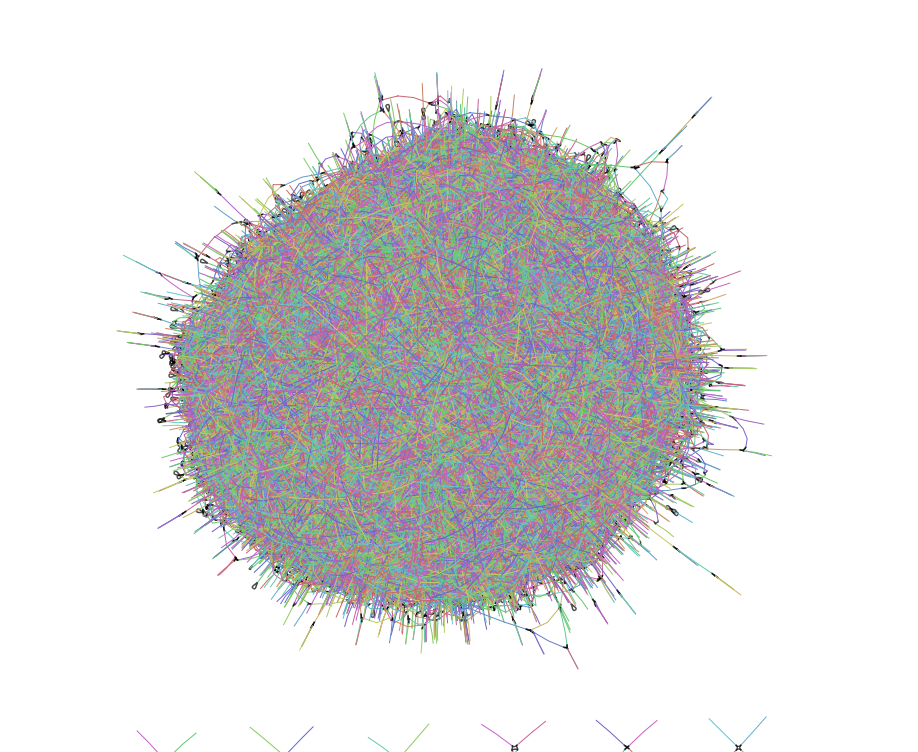



Anchor-based:
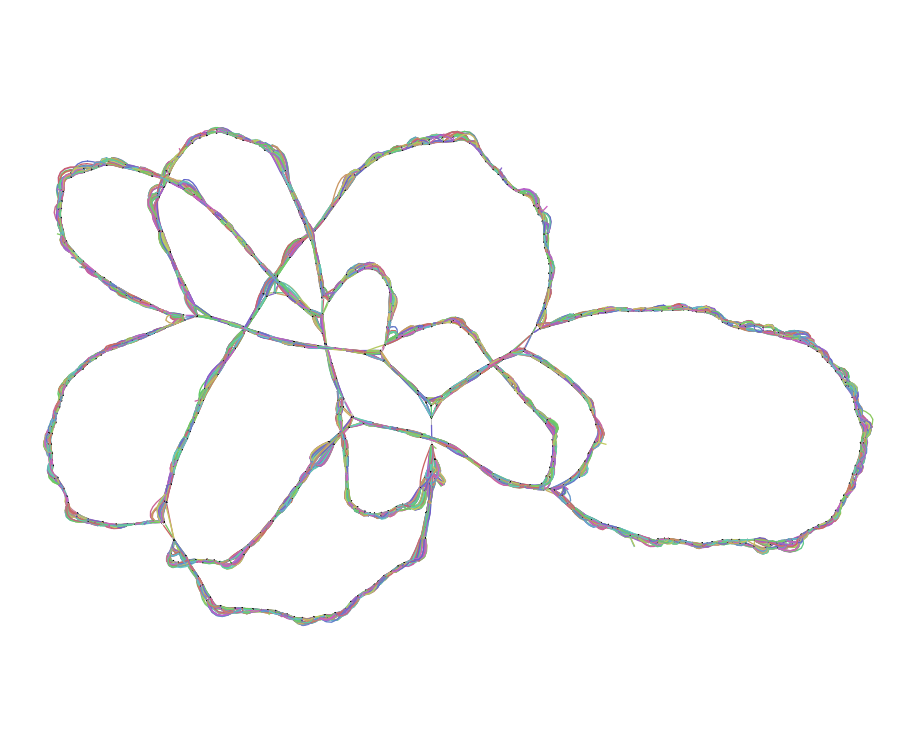
    

Local View:

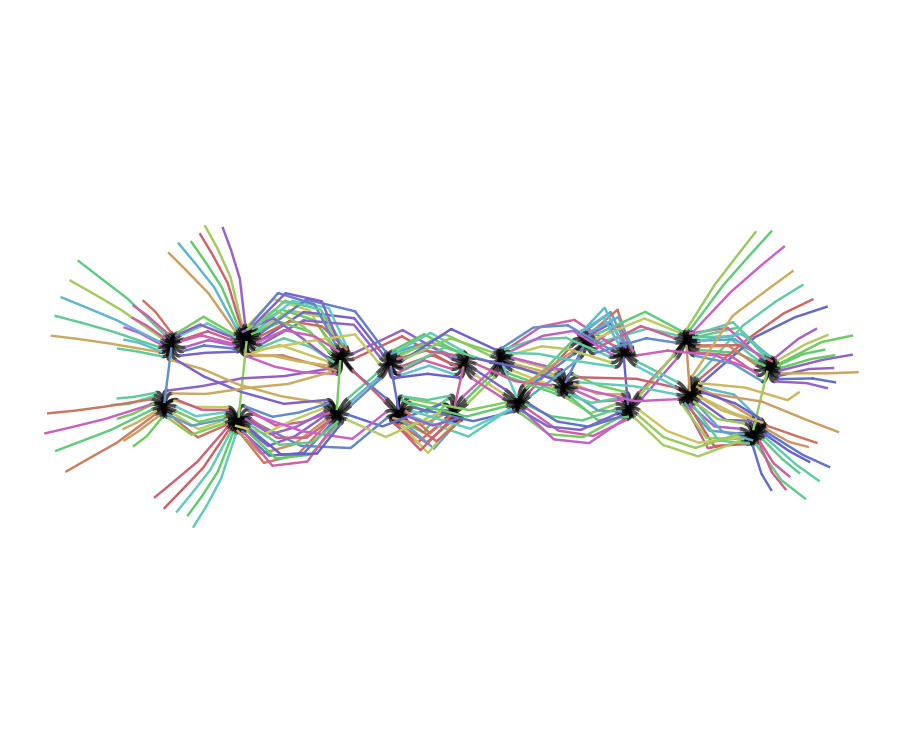

# stats

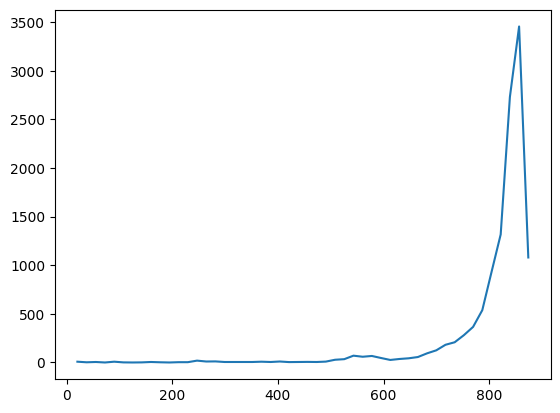

In [40]:
y, x = numpy.histogram(edgenum_perread, bins = 50)
plot.plot(x[1:], y)

In [29]:
Edge_info

{'E00000.0000': {'seq': 'AAACCTGCCCCTACTCC',
  'src': 'SOURCE',
  'dst': 'A001272',
  'reads': ['m54329U_201103_231616/6359354/ccs']},
 'E00000.0001': {'seq': 'TCCTAGACCTAACC',
  'src': 'A001272',
  'dst': 'A001274',
  'reads': ['m54329U_201103_231616/6359354/ccs']},
 'E00000.0002': {'seq': 'TGACTAGAAAAGCTATT',
  'src': 'A001274',
  'dst': 'A001275',
  'reads': ['m54329U_201103_231616/6359354/ccs']},
 'E00000.0003': {'seq': 'ACCTAAAACAATTTCACAGCACC',
  'src': 'A001275',
  'dst': 'A001277',
  'reads': ['m54329U_201103_231616/6359354/ccs']},
 'E00000.0004': {'seq': 'AAATCTCCACCTCCATCA',
  'src': 'A001277',
  'dst': 'A001279',
  'reads': ['m54329U_201103_231616/6359354/ccs']},
 'E00000.0005': {'seq': 'TCACCTCAACCCAAAAAGGCATAATT',
  'src': 'A001279',
  'dst': 'A001281',
  'reads': ['m54329U_201103_231616/6359354/ccs']},
 'E00000.0006': {'seq': 'AAACTTTACTTCCTCTCTTT',
  'src': 'A001281',
  'dst': 'A001283',
  'reads': ['m54329U_201103_231616/6359354/ccs']},
 'E00000.0007': {'seq': 'CTTCTTCC

# Too slow by directly traversing graph

In [93]:
Paths = []
maximal = 15
source = pyfrost.Kmer(AnchorInfo[firstnode]['seq'])
target = pyfrost.Kmer(AnchorInfo[secondnode]['seq'])
visited = set()

def find_paths(g, start, end, sofar = [], depth = 0):
    global Paths, maximal, visited
    # termination by node
    
    if str(start) == str(end):   
        sofar1 = sofar
        Paths.append((sofar1))
        return 

    if depth > maximal:
        return  
    depth1 = depth + 1
    
    if start in visited:
        return
    
    for dst in g.successors(start):               
        find_paths(g, dst, end, sofar = sofar + [start], depth = depth1)

find_paths(g, source, target)

In [94]:
for path in Paths:
    seq = pyfrost.path_sequence(g, path)
    print(seq)

GTCTATCACCCAACTACCACTCACGGGA
GTCTATCACCCACCCACTCACGGGA
GTCTATCACCCACTCACGGGA
GTCTATCACCCCTAACCACTCACGGGA
GTCTATCACCCCTAACCCACTCACGGGA
GTCTATCACCCCTATTAACACTCACGGGA
GTCTATCACCCCTTACCACTCACGGGA
GTCTATCACCCTAACCACTCACGGGA
GTCTATCACCCTAACCCACTCACGGGA
GTCTATCACCCTATTAACACTCACGGGA
GTCTATCACCCTTACCACTCACGGGA
GTCTATCACCCTTTTACCCACTCACGGGA


In [ ]:
# find all paths in the graph
firstnode = AnchorInfo[anchor_unadjacent_list[0]]['seq']
secondnode = AnchorInfo[anchor_unadjacent_list[1]]['seq']
EdgeInfo = {}
edgenum = 0
for i in range(len(anchor_unadjacent_list)-1):
    firstnode = anchor_unadjacent_list[i]
    secondnode = anchor_unadjacent_list[i+1]
    distance = AnchorInfo[secondnode]['pos'] - AnchorInfo[firstnode]['pos']
    print(distance)
    Paths = []
    maximal = distance + 1 # enable maximal 3 distance
    visited = set()
    source = pyfrost.Kmer(AnchorInfo[firstnode]['seq'])
    target = pyfrost.Kmer(AnchorInfo[secondnode]['seq'])
    find_paths(g, source, target)
    print(firstnode, len(Paths))
    
    for path in Paths:
        seq = pyfrost.path_sequence(g, path)
        print(seq)
        edgenum += 1
        edgename = "E%08d" % (edgenum)
        EdgeInfo[edgename] = {}
        EdgeInfo[edgename]['src'] = firstnode
        EdgeInfo[edgename]['dst'] = secondnode
        EdgeInfo[edgename]['seq'] = seq
    break
    

19


In [37]:
#print(nx.has_path(G = g, source = AnchorInfo[firstnode]['seq'], target =AnchorInfo[secondnode]['seq'] ))
#nx.all_shortest_paths(G = g, source = firstnode, target = secondnode)

True


In [45]:
#AnchorInfo[firstnode]['seq']

'ATTAATGCTTG'

In [52]:
# Path = nx.shortest_path(G = g, source = AnchorInfo[firstnode]['seq'], target =AnchorInfo[secondnode]['seq'] )
# index = 0
# for path in Path:
#     index += 1
#     print(path, index)

ATTAATGCTTG 1
TTAATGCTTGA 2
TAATGCTTGAG 3
ATGCTTGAGGA 4
TGCTTGAGGAC 5
TGAGGACATAA 6
GAGGACATAAT 7
AGGACATAATA 8
GGACATAATAA 9


In [92]:
#pyfrost.KmerCounter.count_kmers(pyfrost.Kmer('GGACATAATAA'))

TypeError: count_kmers(): incompatible function arguments. The following argument types are supported:
    1. (self: pyfrostcpp.KmerCounter, arg0: str) -> pyfrostcpp.KmerCounter

Invoked with: <Kmer 'GGACATAATAA'>

In [90]:
#help(pyfrost.KmerCounter)

Help on instancemethod in module pyfrostcpp:

count_kmers(...)
    count_kmers(self: pyfrostcpp.KmerCounter, arg0: str) -> pyfrostcpp.KmerCounter



In [ ]:
# visited = set() # Set to keep track of visited nodes of graph.

# def dfs(visited, graph, node):  #function for dfs 
#     if node not in visited:
#         print (node)
#         visited.add(node)
#         for neighbour in graph[node]:
#             dfs(visited, graph, neighbour)

In [49]:
# maxdepth = 25
# start = AnchorInfo[firstnode]['seq']
# end = AnchorInfo[secondnode]['seq']

# depth = 0
# node = start
# path = []
# while depth < maxdepth:
#     for dst in g.successors(node):

In [46]:

# def find_all_path(g, start, end, sofar = [], depth = 0):
#     """
#     Find Cycles
#     Parameters:
#         start: <int> - Start anchor
#         end: <int> - the anchor next to the start anchor
#     """ 
#     global Path, maxlength
    
#     if depth > maxlength:
#         return
    
#     if start == end:   
#         sofar1 = sofar
#         Path.append(sofar1)
#         return 
    
#     for dst in g.successors(start):
#         find_all_path(g, dst, end, sofar = sofar + [start], depth = depth + 1)


In [ ]:
# Path = []
# maxlength = 25
# find_all_path(g, firstnode, secondnode, sofar = [], depth = 0)

In [48]:
#Path

[]

In [15]:
# print(g.nodes['GTCTATCACCC']['unitig_sequence'])
# print
# for kmer in g.successors('GTCTATCACCC'):
#     print(kmer)

GTCTATCACCC
TCTATCACCCA
TCTATCACCCC
TCTATCACCCT


In [105]:
# for src, dst in g.edges:
#     if len(g.nodes[src]['unitig_sequence']) > 12:
#         print(g.nodes[src]['unitig_sequence'], g.nodes[dst]['unitig_sequence'])
#         break
# #     if str(src) == 'TGAACCGAATT':
# #         print(src, dst)
# #         print(g.nodes[src]['unitig_sequence'])
# #         break

AGCTATAAATGAACA TAAATGAACAA


In [99]:
# for kmer in g.successors('TGAACCGAATT'):
#     print(kmer)

AACCGAATTGG
AACCGAATTGT
